# Section I: Concepts

I'm [John Williamson](http://johnhw.com)

The purpose of this crash course is to give you enough vocabulary to be able to follow the rest of the summer school. There isn't time to cover the details of the methods I'll talk about, the historical orgins and background or much about what techinques and models you might prefer and why. 

Instead, I aim to cover just enough that you can understand the material that follows.



## What is machine learning?

### Machine learning can be summarised as making *predictions* from *data*
This is slightly distinct from statistics, which is traditionally concerned with making inferences from data -- e.g. determining if an effect is present in a scientific study. Instead, machine learning focuses on trying to estimate the value of unknown variables given some data which might predict them. 

Machine learning algorithms generally have a *training* phase, where input data is used to update the parameters of a function that tries to model the data, and a *testing* phase, where data unseen by the learning algorithm is used to evaluate how well the model is able to do prediction.

### Machine learning in HCI
#### Example: gesture recognition
#### Example: language modelling
#### Example: touch prediction
#### Example: sensor fusion

### Some mathematical notation

We will by considering datasets which consist of a series of measurements. We learn from a *training set* of data.
Each measurement is called a *sample* or *datapoint*, and each measurement type is called a *feature*. 

If we have $n$ samples and $d$ features, we form a matrix $X$ of size $n \times d$, which has $n$ rows of $d$ measurements. $d$ is the **dimension** of the measurements. $n$ is the **sample size**.  Each row of $X$ is called a *feature vector*. For example, we might have 200 images of digits, each of which is a sequence of $8\times8=64$ measurements of brightness. The image values are the *features*.

In a supervised learning situation, we will also have a vector of *targets* $Y$. These will be the targets we assign to each of the training feature vectors; one target per row of the training features. 

If we are doing discrete classification, these *targets* will be ordinal *labels* e.g. [0,1]. If we are doing *regression* these will be continuous values. The *targets* can be multi-dimensional (e.g. we could predict two attributes in a regression task), although most common learning tasks have univariate (single-dimensional) targets.

We want to learn a function $$y^\prime = f(x^\prime)$$ which works for a value $x^\prime$ that **we have not seen before**; i.e. we want to be able to **predict** a value $y^\prime$  based on a **model** ($f(x)$) that we learned from data.


In [ ]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import seaborn
import sklearn.preprocessing, sklearn.cluster, sklearn.tree, sklearn.neighbors, sklearn.ensemble, sklearn.multiclass, sklearn.feature_selection
import ipy_table
import sklearn.svm, sklearn.cross_validation, sklearn.grid_search, sklearn.metrics, sklearn.datasets, sklearn.decomposition, sklearn.manifold
import pandas as pd
from sknn.mlp import Classifier, Layer

# force plots to appear inline on this page
%matplotlib inline

### Supervised learning

Supervised learning involves learning a relationship between attribute variables and target variables; in other words learning a function which maps input measurements to target values. This can be in the context of making discrete decisions (is this image a car or not?) or learning continuous relationships (how loud will this aircraft wing be if I make the shape like this?).

### Unsupervised learning
Unsupervised learning learns the structure of data without any explicit labeling of points. The key idea is that datasets may have a simple underlying or *latent* representation which can be determined simply by looking at the data itself.

Two common unsupervised learning tasks are *clustering* and *dimensional reduction*. Clustering can be thought of as the unsupervised analogue of classification -- finding discrete classes in data. Dimensional reduction can be thought of as the analogue of regression -- finding a small set of continuous variables which "explain" a higher dimensional set. 



#### Reinforcement learning
There are other machine learning paradigms, such as **reinforcement learning**, which tries to learn a *policy* (what to do in specific circumstances) using only a *reward function* (was what the algorithm did good or bad?). This is important in learning control tasks, e.g. for autonomous vehicles. We won't cover reinforcement learning here.

#### Black box models
Some learning algorithms produce models which are essentially inscrutable. They are intricate deformations of the initial data and there is no way for a human to meaningfully understand the process by which decisions are produced; the models are *black boxes* that produce predictions. Other models, especially well-defined probabilistic models, have a clear and interpretable structure and it is easy to understand how predictions are arrived at. *Generative models* are probablistic models that can draw samples from the model, and can be easier to interpret that *discriminative models* which simply learn a function that discriminates between distinct classes or values.

A clear and interpretable model can make it much easier to work with the models and to be sure that the assumptions that the model encodes are sensible. However, *black box* models can often be more computationally efficient as well as having better predictive performance in practice.

##### Tank recognition
A (possibly apocryphal) story about the early days of neural networks illustrates the dangers of neural networks. The DoD attempted to build a classifier that would automatically distinguish Soviet tanks from US tanks from images. They collected photographs, digitised them and trained the classifer. The results were extremely promising, with excellent classification performance. However, when new images were taken, the performance in testing was almost at the chance level -- the classifier did not work at all. 

It transpired that in the original training set, Soviet tank photographs had been taken on cloudy days and the US tank photographs on sunny days. The classifier was very good at distinguishing illumination patterns from sunny vs. cloudy days, but had captured nothing of tank qualities.

<img src="imgs/tank.jpg" width="400px">




## Simple learning -- the perceptron

Let's look at a quick example of a simple supervised learning task -- binary classification. That is we take some training features $X$ and some *binary indicator* labels $Y$ and learn a function $f(x)$ which has two possible outputs: [0,1] (or equivalently [-1,1]). 

A very simple such classifier is the *perceptron* which attempts to find a linear weighting of the inputs such that the sign of the output matches the class label. In 2D this would be drawing a line between the two classes; in the 3D a plane and so on.

The function that will be learned is *linear* (i.e. is just a weighting of the inputs). Since there is only one output variable, the weights a 1D vector, and these weights are denoted $w$. There are $d$ weights, one for each feature. The function to be learned is of the form:
$$f(x) = \sgn(w^Tx),$$
where $\sgn$ is the sign function and $w^T$ is the weights transposed so as to form the weighted sum.

We can get some insight into what the perceptron is doing by plotting the *decision boundary* in the feature space. This shows us which parts of the space the classifier indicates are +1 and which are -1. We do this just by evaluating $f(x)$ over a grid of points.


In [ ]:
### Perceptron demo
iris = sklearn.datasets.load_iris()
# we just choose a 2D slice of this data
iris_2d = iris.data[:,0:2]

# plot the 2D data
plt.scatter(iris_2d[:,0], iris_2d[:,1], c=iris.target, cmap='jet')
plt.title("Original iris data")

# make binary targets (either class 0 or other class)
binary = np.where(iris.target==0, -1, 1)
plt.figure()
plt.scatter(iris_2d[:,0], iris_2d[:,1], c=binary, cmap='jet')
plt.title("Binary classes")

# find a separating plane
per = sklearn.linear_model.Perceptron( n_iter=5, eta0=1)
# "warm up" and fill in the coefficients
per.partial_fit(iris_2d, binary, [-1,1])

def fit_perceptron(x):
    # apply 20 steps
    for i in range(20):
        per.partial_fit(x, binary, [-1,1])
    
def plot_perceptron(x):
    # plot the original data
    plt.figure()        
    # predict output value across the space
    res = 150
    
    # we generate a set of points covering the x,y space
    xm, ym = np.meshgrid(np.linspace(0,8,res), np.linspace(0,5,res))
    # then predict the perceptron output value at each position
    zm = per.predict(np.c_[xm.ravel(), ym.ravel()])
    zm = zm.reshape(xm.shape)
    # and plot it
    plt.contourf(xm,ym,zm, cmap='Paired')
    
    plt.scatter(x[:,0], x[:,1], c=binary, cmap='jet')

    
for i in range(5):
    fit_perceptron(iris_2d)
    plot_perceptron(iris_2d)
    






We can render the decision function in 3D to give a different perspective on what is going on:

In [ ]:

def plot_perceptron_3d():
    # predict output value across the space
    res = 50
    
    # we generate a set of points covering the x,y space
    xm, ym = np.meshgrid(np.linspace(0,8,res), np.linspace(0,5,res))
    # then predict the perceptron output value at each position
    zm = per.predict(np.c_[xm.ravel(), ym.ravel()])*0.5
    zm = zm.reshape(xm.shape)
    # and plot it
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xm,ym,zm, cmap='Paired', alpha=0.5)
    ax.set_zlim(-1,1)
    ax.view_init(elev=40, azim=50)
    
    
    
    ax.scatter(iris_2d[:,0], iris_2d[:,1], np.zeros_like(iris_2d[:,0]), c=binary, cmap='jet')
    
    
plot_perceptron_3d()    

The perceptron is very simple, but can only learn functions that divide the feature space with a hyperplane. If the datapoints to be classified have classes that cannot be separated this way in the feature space, the perceptron cannot learn the function.





In [ ]:

circles = sklearn.datasets.make_circles(500, noise=0.02)

# find a separating plane
per = sklearn.linear_model.Perceptron( n_iter=500, eta0=1)
# "warm up" and fill in the coefficients
per.fit(circles[0], circles[1], [-1,1])

res = 150
    
# we generate a set of points covering the x,y space
xm, ym = np.meshgrid(np.linspace(-2,2,res), np.linspace(-2,2,res))
# then predict the perceptron output value at each position
zm = per.predict(np.c_[xm.ravel(), ym.ravel()])
zm = zm.reshape(xm.shape)
# and plot it
plt.contourf(xm,ym,zm, cmap='Paired')
    
# plot the 2D data
plt.scatter(circles[0][:,0], circles[0][:,1], c=circles[1], cmap='jet')
plt.title("Original circle data")
plt.axis("equal")


However, if the features are transformed in a way that "unravels" the data so that a hyperplane can separate them, then the model can learn the function correctly. 

## K Nearest Neighbors (KNN)
A very simple way of classifying data is to predict class labels by looking at the class labels of the datapoints nearest to the  point we are trying to predict. By finding the nearest $k$ neighbours in the original dataset $X$ of a new point $x^\prime$, we can predict a class label $y$ by majority voting from the class labels of those $k$ neighbours (i.e. the label which occurs most often among those neighbours).

kNN can deal with multi-class problems without any changes. It can also be used for *regression* tasks by interpolating the output of the neighbours (e.g. linearly) rather than using majority voting.

This is a very simple to implement algorithm, and it works relatively well for many cases. It is a good baseline for performance -- kNN has few parameters to tune, and is easy to apply, although can be computationally expensive for large datasets.  More sophisticated algorithms can do much better, but their behaviour can be hard to predict, and a sensible check if a more sophisticated algortithm is doing something useful is to compare it with the KNN performance.



In [ ]:
# k neareset neigbbours classification example, again with the Iris dataset

def plot_knn(knn):
    # plot the original data
    plt.figure()        
    # predict output value across the space
    res = 80
    xm, ym = np.meshgrid(np.linspace(0,8,res), np.linspace(0,5,res))
    zm = knn.predict(np.c_[xm.ravel(), ym.ravel()])
    zm = zm.reshape(xm.shape)
    plt.contourf(xm,ym,zm, cmap='Paired')
    
    plt.scatter(iris_2d[:,0], iris_2d[:,1], c=iris.target, cmap='jet')
    
# Use Euclidean norm
knn = sklearn.neighbors.KNeighborsClassifier(5)
knn.fit(iris_2d, iris.target)
plot_knn(knn)

# use L1  / taxicab norm
knn = sklearn.neighbors.KNeighborsClassifier(5, p=1)
knn.fit(iris_2d, iris.target)
plot_knn(knn)


#### Dimensional reduction
A very common unsuperised learning task is *dimensional reduction*; taking a dataset with a dimension of $d$ and reducing to a dimension of $d^\prime$ which is smaller than $d$ but retains as much of the useful information as possible. 

This can be thought of as a form of lossy compression -- finding a "simpler" representation of the data which captures its essential properties. This of course depends upon what the "essential properties" that we want to keep are, but generally we want to reject *noise* and keep non-random structure. We find a **subspace** that captures the meaningful variation of a dataset.

One way of viewing this process is finding *latent variables*; variables we did not directly observe, but which are simple explanations of the ones we did observe. For example, if we measure a large number of weather measurements (rainfall, pressure, humidity, windspeed), these might be a very redundant representation of a few simple variables (e.g. is there a storm?). If features correlate or cluster in the measured data we can learn this structure *even without knowing training labels*.

#### Visualisation
Dimensional reduction has an obvious role in visualisation, reducing datasets to 2D or 3D representations that humans can work with. It often possible to find a mapping from high to low dimensions which maintains salient structure; e.g. one in which different classes of data are visually separated.

#### Pre-training
Another important use for dimensional reduction is in learning a simplified feature vector for subsequent supervised learning. If much of the irrelevant variation can be "factored out" by the dimensional reduction process, then the decision problem for the supervised learning algorithm becomes easier. This is known as *pre-training*. 

This process can also dramatically speed up some supervised learning algorithms which have a time complexity which scales badly with $d$ (e.g. $O(d^2)$ or even $(O(d^3)$).




#### Principal component analysis
One very simple method of dimensional reduction is *principal component analysis*. This is a linear method; in other words it finds rigid rotations and scalings of the data to project it onto a lower dimension. That is, it finds a matrix $A$ such that $y=Ax$ gives a mapping from $d$ dimensional $x$ to $d^\prime$ dimensional $y$.

The PCA algorithm effectively looks for the rotation that makes the dataset look "fattest" (maximises the variance), chooses that as the first dimension, then removes that dimension, rotates again to make it look "fattest" and repeats. Linear algebra makes it efficient to do this process in a single step by extracting the *eigenvectors* of the *covariance matrix*. 

PCA always finds a matrix $A$ such that $y = Ax$, where the dimension of $y<x$. PCA is exact and repeatable and very efficient, but it can only find rigid transformations of the data. This is a limitation of any linear dimensional reduction technique.




In [ ]:
digits = sklearn.datasets.load_digits()
digit_data = digits.data

# plot a single digit data element
def show_digit(d):
    plt.imshow(d.reshape(8,8), cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.figure()
    
# show a couple of raw digits
show_digit(digit_data[0])
show_digit(digit_data[400])

# apply principal component analysis
pca = sklearn.decomposition.PCA(n_components=2).fit(digit_data)
digits_2d = pca.transform(digit_data)

# plot each digit with a different color
plt.scatter(digits_2d[:,0], digits_2d[:,1], c=digits.target, cmap='jet')


One useful property of PCA is that we compute exactly how "fat" each of these learned dimensions were. The ratio of *explained variance* tells us how much each of the original variation in the dataset is captured by each learned dimension. 

If most of the variance is in the first couple of components, we know that a 2D representation will capture much of the original dataset. If the ratios of variance are spread out over many dimensions, we will need many dimensions to represent the data well. 

In [ ]:
# We can see how many dimensions we need to represent the data well using the eigenspectrum
# here we show the first 32 components
pca = sklearn.decomposition.PCA(n_components=32).fit(digit_data)
plt.bar(np.arange(32), pca.explained_variance_ratio_)
plt.xlabel("Component")
plt.ylabel("Proportion of variance explained")

One example where PCA does badly is the "swiss roll dataset" -- a plane rolled up into a spiral in 3D. This has a very simple structure; a simple plane with some distortion. But PCA can never unravel the spiral to find this simple explanation because it cannot be unravelled via a linear transformation.

In [ ]:
swiss_pos, swiss_val = sklearn.datasets.make_swiss_roll(800, noise=0.0)
fig = plt.figure()
# make a 3D figure
ax = fig.add_subplot(111, projection="3d")
ax.scatter(swiss_pos[:,0], swiss_pos[:,1], swiss_pos[:,2], c=swiss_val, cmap='gist_heat', s=10)


In [ ]:
# Apply PCA to learn this structure (which doesn't help much)
pca = sklearn.decomposition.PCA(2).fit(swiss_pos)
pca_pos = pca.transform(swiss_pos)
plt.scatter(pca_pos[:,0], pca_pos[:,1], c=swiss_val, cmap='gist_heat')

##### Manifold learning
Other approaches to dimensional reduction look at the problem in terms of learning a *manifold*. A *manifold* is a geometrical structure which is locally like a low-dimensional Euclidean space. Examples are the plane rolled up in the swiss roll, or a 1D "string" tangled up in a 3D space. 

Manifold approaches attempt to automatically find these smooth embedded structures by examining the local structure of datapoints (often by analysing the nearest neighbour graph of points). This is more flexible than linear dimensional reduction as it can in theory unravel very complex or tangled datasets. 

However, the algorithms are usually approximate, they do not give guarantees that they will find a given manifold, and can be computationally intensive to run.

A popular manifold learning algorithm is *ISOMAP* which uses nearest neighbour graphs to identify locally connected parts of a dataset.



In [ ]:
isomap_pos = sklearn.manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(swiss_pos)
plt.scatter(isomap_pos[:,0], isomap_pos[:,1], c=swiss_val, cmap='gist_heat')
plt.figure()

# note that isomap is sensitive to noise!
noisy_swiss_pos, swiss_val = sklearn.datasets.make_swiss_roll(800, noise=0.5)
isomap_pos = sklearn.manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(noisy_swiss_pos)
plt.scatter(isomap_pos[:,0], isomap_pos[:,1], c=swiss_val, cmap='gist_heat')


We can apply a more modern dimensional reduction method -- t-distributed stochastic neighbour embedding -- to the digits dataset we used in the PCA example.

In [ ]:
# This is very slow to run
tsne_digits = sklearn.manifold.TSNE(n_components=2).fit_transform(digit_data)
plt.scatter(tsne_digits[:,0], tsne_digits[:,1], c=digits.target, cmap='jet')

t-SNE separates out the digits very nicely into separate regions one for each digit, from the image data alone.

#### Clustering
Clustering tries to find well-seperated (in some sense) partitions of a data set. It is essentially a search for natural boundaries in the data. An example use of clustering might be gathering data from a large number of plants (e.g. measuring flower sizes, colouring, leaf symmetries, etc.) and then applying clustering to the data to try and separate out potential species groupings. 

There are many clustering approaches. A simple one is *k-means*, which finds clusters via an iterative algortihm. The number of clusters must be chosen in advance. In general, it is hard to estimate the number of clusters, although there are algorithms for estimating this. k-means proceeds by choosing a set of $k$ random points as initial cluster seed points; classifiying each data point according to its nearest seed point; then moving the cluster point towards the mean position of all the data points that belong to it. 

The k-means algorithm does not guarantee to find the best possible clustering -- it falls into *local minima*.



In [ ]:
# this is the classic "Iris" dataset, that captures 4 attributes measured from various irises (of three distinct species)
iris = sklearn.datasets.load_iris()

# we plot the dataset on two of the dimensions
plt.scatter(iris.data[:,2], iris.data[:,1], c=iris.target, cmap='jet')

plt.figure()
# now we cluster *without* any knowledge of the true class labels
kmeans = sklearn.cluster.KMeans(n_clusters=3)
kmeans_target = kmeans.fit_predict(iris.data)
plt.scatter(iris.data[:,2], iris.data[:,1], c=kmeans_target, cmap='jet')
# plot the cluster centres
plt.plot(kmeans.cluster_centers_[:,2], kmeans.cluster_centers_[:,1], 'r*', markersize=20)

## if we get the number of clusters wrong, the algorithm hallucinates clusters where there are none:
plt.figure()
# now we try and find 5 clusters
kmeans = sklearn.cluster.KMeans(n_clusters=5)
kmeans_target = kmeans.fit_predict(iris.data)
plt.scatter(iris.data[:,2], iris.data[:,1], c=kmeans_target, cmap='jet')
# plot the cluster centres
plt.plot(kmeans.cluster_centers_[:,2], kmeans.cluster_centers_[:,1], 'r*', markersize=20)



#### Agglomerative clustering
Another approach is to consider the clustering from bottom-up instead of top-down. *Agglomerative clustering* merges pairs of data points together, creating a tree of neighbour clusters. Once the preset number of leaves have been formed, these are returned as the clusters

In [ ]:
# we plot the dataset on two of the dimensions
plt.scatter(iris.data[:,2], iris.data[:,1], c=iris.target, cmap='jet')

plt.figure()
agg = sklearn.cluster.AgglomerativeClustering(n_clusters=3)
agg_target = agg.fit_predict(iris.data)
plt.scatter(iris.data[:,2], iris.data[:,1], c=agg_target, cmap='jet')


### Feature vectors
In almost all machine learning contexts, we predict outputs given a **fixed length** set of features; the input space a fixed dimension $d$. Each of those features is usually (but not always) continuous-valued.

This means that any data we want to process must be converted to fixed length real-valued vectors. Some data is already in this form (e.g. a set of weather measurements at a given time: pressure, humidity, temperature). In other cases, it is more awkward to find a space in which to represent the data.


For example, we often want to make predictions based on *time series*; a set of measurements of the same variable (or variables) made repeatedly over time. This includes problems like speech recognition, where we have acoustic measurements made over a period of time, or predicting the chance of a car's brakes failing given a the time history of the speed of the car and the reflectivity of the tires (as a measure water-loggedness). 

In these cases we have regularly sampled data (i.e. time between measurements is constant). 

#### Windowing
One general solution to this time series problem is to use a *delay embedding* -- a fixed length sequence of previous measurements. For example the measurements $[x_{t=t}, x_{t=t-1}, x_{t=t-2}, \dots, x_{t=t-d}]$ might make up the feature vector. A general delay embedding does not need to capture equally spaced delayed elements: it could capture $x_{t}, x_{t-5}, x_{t-10}, x_{t-20}, x_{t-40}$. Choosing the spacing of these captures can be tricky. If we just use $d$ consecutive measurements, this process is known as *windowing*, because we chop up the data into fixed length windows by "sliding" a time window along the data.

These windows can overlap, which increases the size of the training set, but excessive overlapping can capture lots of redundant features. Balancing the size of the windows (and thus the feature vector size $d$) and the amount of overlap is a matter of experimentation and domain knowledge.





In [ ]:
# windowing example

t = np.linspace(0,20,1000)
x = (1+0.1*t)*np.cos(t) + np.cos(t*8+0.2)*0.4 + np.cos(t*3+3)*0.1 + np.random.normal(0,0.1,t.shape)

# show windows
def plot_windows(t,x,window_size,overlap):
    plt.figure()
    plt.plot(t,x)
    end = window_size
    while end<len(t):
        plt.fill_between(t[end-window_size:end]+0.01, -4,4, facecolor='r', edgecolor='k',alpha=0.1)
        plt.fill_between(t[end-window_size:end]+0.01, -4,4, facecolor='none', edgecolor='k',alpha=0.5)
        
        end += window_size-overlap

# d = 100
plot_windows(t,x,100,0)
plt.title("$d=100$")
# d = 500
plot_windows(t,x,400,0)
plt.title("$d=500$")
# d = 100, overlap = 50
plot_windows(t,x,100,50)
plt.title("$d=100, k=50$")
# d = 400, overlap = 350
plot_windows(t,x,400,350)
plt.title("$d=400, k=350$")

# skipping 
# d = 100, overlap = -100
plot_windows(t,x,100, -150)
plt.title("$d=100, k=-150$")



## Features, labels, data formats
We've worked so far with *real valued* data -- i.e. where the features $X$ take on continuous values. Regression involves learning real-valued output $y$ and classification deals with *categorical* outputs $y$.

Categorical data must be treated differently from real data because categorical variables are discrete and have no inherent ordering or scaling. Categorical variables encode distinct classes, e.g. "car", "bus", "train".

Ordinal variables are variables that have a distinct set of discrete values with an ordering (e.g. responses on a Likert scale on a questionnaire) but do not have a constant scaling (the difference between 1 and 2 might be totally different from 8 and 9).

There are specific algorithms to learn function with categorical and ordinal inputs and outputs. In general, algorithms for continuous data are **not** suitable directly.

#### One-hot-encoding

One way of converting a categorical value to a real valued vector is to use *one hot encoding*. This replaces each category from $k$ categories with a binary vector with a single 1, producing $k$ distinct vectors. For example, if we had categories: "bird", "mammal", "reptile", "amphibian", we might create *target vectors*:
$$[1,0,0,0],\\
[0,1,0,0],\\
[0,0,1,0],\\
[0,0,0,1]$$
These lie at the vertices of a simplex (the high-dimensional analogue of a triangle) and are easy to separate. There are other approaches which use *error-correcting codes* to increase efficiency when $k$ is large, to avoid having very long sparse vectors.



In [ ]:
def one_hot_encode(categories):
    """Return a dictionary with binary one-hot vector for each category"""
    n = len(categories)
    one_hot = {}
    for i in range(n):
        binary_vector = [0 for k in range(n)]
        binary_vector[i] = 1
        one_hot[categories[i]] = binary_vector
    return one_hot

print one_hot_encode([1,2,3,4,5,6])
print one_hot_encode(["cat", "dog", "horse", "cow", "sheep"])


#### Multi-class approaches
There are many classifiers (such as the perceptron) which only produce binary labels (is the data point one side of the datapoint or the other?). If there are multiple output classes, we need a way of building a *multi-class classifier* from a set of binary ones.

There are two popular approaches: *one-vs-all* and *one-vs-one*.

###### One-vs-alll
*One-vs-all* classifiers classify $k$ different target labels by training $k$ distinct binary classifiers, each of which predicts whether or not the output class $y$ is $y=i$ for the $i$th classifier. In other words, it classifies whether each point is either a member of the specific class or of the "whole world".

A simple maximum is used to select the classifier with the largest output, and the index of this classifier becomes the class label. 

###### One-vs-one
An alternative approach is to train classifiers for each *pair* of classes. This needs $k(k-1)$ classifiers for $k$ distinct target labels. This generally requires more training data (as the data is spread more thinly over the classifiers) and doesn't scale well to large values of $k$. 





In [ ]:
### Perceptron demo using one-vs-all
iris = sklearn.datasets.load_iris()

# find a separating plane
per = sklearn.linear_model.Perceptron( n_iter=5000, eta0=1)
multi_class_per = sklearn.multiclass.OneVsRestClassifier(per)
iris_2d = iris.data[:,1:3]
multi_class_per.fit(iris_2d, iris.target)

    
def plot_perceptron_multiclass(x):
    # plot the original data
    plt.figure()        
    # predict output value across the space
    res = 150    
    # we generate a set of points covering the x,y space
    xm, ym = np.meshgrid(np.linspace(0,8,res), np.linspace(0,8
                                                           ,res))
    # then predict the perceptron output value at each position
    zm = multi_class_per.predict(np.c_[xm.ravel(), ym.ravel()])
    zm = zm.reshape(xm.shape)
    # and plot it
    plt.contourf(xm,ym,zm, cmap='jet')
    
    plt.scatter(x[:,0], x[:,1], c=iris.target, cmap='jet')

    plt.figure()
    zm1 = multi_class_per.estimators_[0].predict(np.c_[xm.ravel(), ym.ravel()])
    zm1 = zm1.reshape(xm.shape)
    # and plot it
    plt.contourf(xm,ym,zm1, cmap='jet')
    
    plt.figure()
    zm2 = multi_class_per.estimators_[1].predict(np.c_[xm.ravel(), ym.ravel()])
    zm2 = zm2.reshape(xm.shape)
    # and plot it
    plt.contourf(xm,ym,zm2, cmap='jet')
    
    plt.figure()
    zm3 = multi_class_per.estimators_[2].predict(np.c_[xm.ravel(), ym.ravel()])
    zm3 = zm3.reshape(xm.shape)
    # and plot it
    plt.contourf(xm,ym,zm3, cmap='jet')
    
    plt.figure()
    plt.contourf(xm,ym,zm1, cmap='jet', alpha=0.2)
    plt.contourf(xm,ym,zm2, cmap='jet', alpha=0.2)
    plt.contourf(xm,ym,zm3, cmap='jet', alpha=0.2)
    
    
    
    
plot_perceptron_multiclass(iris_2d)







#### Single-class classifiers
So-called "single class" classifiers operate on slightly different basis than conventional classifiers. They are essentially **unsupervised** learning algorithms which learn to predict whether a sample is similar to ones seen before; i.e. whether it follows the distribution of the training data. 

This is **anomaly detection** -- detecting data that is outside the "normal parameters" without explicitly training on out-of-class data.

In [ ]:
from matplotlib.patches import Ellipse
# plot some data with a normal distribution, plus a few outliers that are not part of the model

def anomaly_plot():
    x = np.random.normal(0, 1, (200,2))
    tr = np.array([[0.5, -0.2], [0.9, 0.3]])
    x = np.dot(x,tr)
    plt.scatter(x[:,0], x[:,1])
    
    for i in range(3):
        scale = 0.5+i*0.2
        e = Ellipse(xy=[0,0], width=3*scale, height=8*scale, angle=100, alpha=0.2)
        plt.gca().add_artist(e)
    x2 = np.random.normal(4, 3, (5,2))
    plt.scatter(x2[:,0], x2[:,1], marker='x', c='r', s=40)
    
    
anomaly_plot()

#### Feature selection
Often the number of features in the "raw" measurements are very large (e.g. in EEG, we might measure time series at 64 electrodes, each with 32 spectral features). But this raw representation is very redundant, and the redundancy can both make training very slow and can cause the classifier to learn irrelevant variations in high-dimensional space that are essentially noise.

There are algorithms which can perform *feature selection*, identifying an optimal subset of features that maximise test performance. A simple algorithm is just to randomly drop features and test the resulting classifier, but this is not efficient. Binary search over features can be used for selection

Other algorithms can form linear combination of features, essentially performing dimensional reduction before supervised learning begins.


In [ ]:
# load the "Sonar" data set [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)]
# This is a set of 60 sonar measurements, from bouncing sonar waves off either rocks ("R") or mines ("M")
# The problem is to tell the mines apart from the rocks
%cd datasets/uci

sonar_data = pd.read_csv("sonar.all-data")

# separate features
sonar_features = np.array(sonar_data)[:,0:60].astype(np.float64)

# we use label_binarize to convert "M" and "R" labels into {0,1}
# the ravel() just flattens the resulting 1D matrix into a vector
sonar_labels = sklearn.preprocessing.label_binarize(np.array(sonar_data)[:,60], classes=['M', 'R']).ravel()

# split into a train and test section, holding out 20% (0.2) of the data for testing
sonar_train_features, sonar_test_features, sonar_train_labels, sonar_test_labels = sklearn.cross_validation.train_test_split(
    sonar_features, sonar_labels, test_size=0.3, random_state=0)

In [ ]:
# choose 10 best features
k_best = sklearn.feature_selection.SelectKBest(k=10)
sonar_k_features = k_best.fit_transform(sonar_train_features, sonar_train_labels)

# fit an SVM with the default parameters
svm = sklearn.svm.SVC(C=10, gamma=0.1)
svm.fit(sonar_k_features, sonar_train_labels)
print "10 feature score: %f" % svm.score(k_best.transform(sonar_test_features), sonar_test_labels)

svm = sklearn.svm.SVC(C=10, gamma=0.1)
svm.fit(sonar_train_features, sonar_train_labels)
print "60 feature score: %f" % svm.score(sonar_test_features, sonar_test_labels)



### Hyperparameters
Learning algorithms have *parameters* which characterise the function $f(x)$ that they learn; e.g. the weights $w$ in the perceptron model. These are values that specifically capture the function $f(x)$ for a given dataset.

But there are parameters which are used to **estimate** these parameters or weights. These are *hyperparameters*. These specify how the learning algorithm performs. For example, the $k$ in $k$-means clustering or in kNN classification. Often the learning is an *optimisation* process, where the algorithm iteratively adjusts parameters to minimise some criterion (such as error rate). Hyperparameters include the length of steps taken or whether any smoothing of those steps is to be performed.

Some models have few hyperparameters or are very insenstive to their values. One powerful class of models that is very sensitive to hyperparameter settings are *neural networks* which are very flexible, but tuning of them is something of an art. 



#### Neural nets
Neural networks consist of units like the perceptron (a linear weighting followed by a threshold), but use a *squashing function* rather than a hard threshold to give smooth decisions. Multiple of these weight/squash units are connected together in a network that can very flexibly model functions. In fact, the main issue with neural networks is forcing them to learn the function we really want to learn and not random fluctuations in the data.

Neural networks use *gradient descent* to learn the model weights; that is, the algorithm computes the change in weights with respect to an error function and makes a step in that direction. The length of this step, the size of the network, the squashing function used and various other sophistications that can be applied all result in hyperparameters.


In [ ]:

from sknn.mlp import Classifier, Layer
nn = Classifier(
    layers=[
        Layer("Rectifier", units=20),
        Layer("Linear")],
    learning_rate=0.02,
    n_iter=10)
nn.fit(sonar_train_features, sonar_train_labels)


#### Batches, online learning, mini-batches
Some learning algorithms need to (or it can be beneficial) see the entire training data $X$ at once: this is *batch learning*. An alternative approach is *online learning*, where each sample from $X$ can be presented to the algorithm one at a time and the parameters updated as required. *Online learning* makes it possible to observe how the learning process is performing, and is essential in contexts where the model must be updated on-the-fly.

*Mini-batch learning* presents multiple samples from $X$ at once (e.g. 100 data points) and updates, then presents another mini-batch of samples and so on. This can be an efficient compromise between online learning and batch learning.

#### Loss functions
Learning algorithms often operate as *optimisation algorithms*; i.e. they try to adjust a set of parameters in a parametric model which maps features to predicted targets to minimise some *loss function*. The specific choice of *loss function* is important in getting optimal performance. 

#### Gradient descent 
##### Stochastic gradient descent
#### Unbalanced data
#### Solutions for unbalanced data

In [ ]:
%cd datasets/uci
%ls

## Evaluating machine learning
We need to be able to quantify how well our learning algorithms perform on predicting *unseen* data given the model that has been learned. This involves testing on data that was **not** presented to the learning algorithm during the training phase.

### Classifiers
One common problem is to measure the performance of a *classifier*; i.e. how well the learned function predicts labels for unseen data. An obvious metric is *accuracy*, the ratio of correctly classified examples to the total number of examples.




In [ ]:
# load the "Sonar" data set [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)]
# This is a set of 60 sonar measurements, from bouncing sonar waves off either rocks ("R") or mines ("M")
# The problem is to tell the mines apart from the rocks
sonar_data = pd.read_csv("sonar.all-data")

# separate features
sonar_features = np.array(sonar_data)[:,0:60].astype(np.float64)

# we use label_binarize to convert "M" and "R" labels into {0,1}
# the ravel() just flattens the resulting 1D matrix into a vector
sonar_labels = sklearn.preprocessing.label_binarize(np.array(sonar_data)[:,60], classes=['M', 'R'])[:,0]

# split into a train and test section, holding out 20% (0.2) of the data for testing
sonar_train_features, sonar_test_features, sonar_train_labels, sonar_test_labels = sklearn.cross_validation.train_test_split(
    sonar_features, sonar_labels, test_size=0.3, random_state=0)


# fit an SVM with the default parameters
svm = sklearn.svm.SVC(C=1)
svm.fit(sonar_train_features, sonar_train_labels)
print "Score: %f" % svm.score(sonar_test_features, sonar_test_labels)

sonar_predicted_labels = svm.predict(sonar_test_features)

#### Why is accuracy not enough?
This is an easy to interpret but insufficient metric for performance. One common situation where it fails is where the dataset is not balanced (e.g. there are many more examples for one label than another). If 95% of the dataset are of class 0, and 5% of class 1, **predicting 0 regardless of the input** has a 95% accuracy rate.

#### Measures of performance
In binary classification tasks, it does not distinguish between false positives and false negatives (e.g. in a biometric system, the chance of accepting the wrong user as the owner and the chance of rejecting the real user as the owner), which often have quite different impacts. The *false reject rate* (FRR) and *false accept rate* (FAR) are often used in this context, along with the *true positive rate* (TPR or sensitivity) and *true negative rate* (TNR or specificity).  

The *F1 score* is a metric that combines these as summary score:
$$F_1 = \frac{2 \text{TP}} {2\text{TP} + \text{FN} + \text{FR}},$$ where *TN*, *FR* are the counts of true positive, false rejects, etc. (as opposed to the rates).

The *precision* measures how likely the classifier is to include incorrect results; the *recall* is the how likely the classifier is to include all of the correct results.



In [ ]:

print "Accuracy=%f" % sklearn.metrics.accuracy_score(sonar_test_labels, sonar_predicted_labels)
# recall -- how many of the positive samples did it find?
print "Recall=%f" % sklearn.metrics.recall_score(sonar_test_labels, sonar_predicted_labels)
# precision  -- how many of the negative samples did it reject?
print "Precision=%f" % sklearn.metrics.precision_score(sonar_test_labels, sonar_predicted_labels)

# F1 =  2 * (precision * recall) / (precision + recall)
print "F1 score=%f" % sklearn.metrics.f1_score(sonar_test_labels, sonar_predicted_labels)

#### Confusion matrices
Confusion matrices are effective tools for communicating where classifiers are going wrong: which labels are being confused with which? A confusion matrix shows the distribution of predicted labels for each true label as a matrix of size $l \times l$ for $l$ labels. 

Perfect classification results in a confusion matrix with a single diagonal of 1s (every test example predicts the label to be the true label). This matrix can reveal classes which are poorly separated in multi-class problems.


In [ ]:
# we can print the confusion matrix
confusion_matrix =  sklearn.metrics.confusion_matrix(sonar_test_labels, sonar_predicted_labels).astype(np.float64)
# normalise so that sum(row)=1
confusion_matrix = (confusion_matrix.T / np.sum(confusion_matrix, axis=1)).T
# ipy_table.make_table just pretty prints the resulting matrix
ipy_table.make_table(confusion_matrix)

#### Receiver-operator curves
A very useful tool for capturing binary classification performance is the *receiver-operator curve* (ROC curve). This works with any classifier that produces **scores** as outputs (e.g. continuous values in the range [0,1]). Classifiers that only produce discrete class labels cannot be used to generate a ROC curve.

To plot the curve, we iterate through a set of threshold values $\tau_1, \tau_2, \dots$, and plot the accuracy we would get if we thresholded the classifiers at $\tau_i$. A classifier with chance performance will have an ROC curve with $y=x$; a very good classifier will have the curve bent up towards the upper-left corner.

In [ ]:
# we can plot the receiver-operator curve: the graph of false positive rate against true positive rate
scores = svm.decision_function(sonar_test_features)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(sonar_test_labels, scores)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1])
plt.plot([0,1], [1,0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["ROC", "Chance"])

## AUC
The *area under the curve* (AUC) of the ROC curve (i.e. the integral of the ROC curve) is a useful summary metric for performance.
An AUC of 1.0 indicates perfect classification. An AUC of 0.5 indicates chance performance.


In [ ]:
print "AUC=%f" % sklearn.metrics.roc_auc_score(sonar_test_labels, scores)

In [ ]:
print sklearn.metrics.classification_report(sonar_test_labels, sonar_predicted_labels)

In [ ]:

# let's search for the best parameters of C and gamma
# we create a grid of parameter values, log-spaced across a wide range
C_vals = np.logspace(-2,8,10)
gamma_vals = np.logspace(-4,3,10)

# 10x10 values of C and gamma; 10 fold cross validation for each
grid_cv = sklearn.grid_search.GridSearchCV(svm, {'C':C_vals, 'gamma':gamma_vals}, cv=10)
grid_cv.fit(sonar_train_features, sonar_train_labels)


In [ ]:
# print the optimal best results
print grid_cv.best_params_
print grid_cv.best_score_


In [ ]:
# fit an SVM using the optimal parameters found
svm = sklearn.svm.SVC(C=grid_cv.best_params_['C'], gamma=grid_cv.best_params_['gamma'])
svm.fit(sonar_train_features, sonar_train_labels)
print "Score: %f" % svm.score(sonar_test_features, sonar_test_labels)

In [ ]:
# We can randomly permute the label vectors using np.random.permutation
# Now they have no relation to the training features
random_sonar_train_labels = np.random.permutation(sonar_train_labels)
random_sonar_test_labels = np.random.permutation(sonar_test_labels)


In [ ]:
# fit an SVM to the randomised label data
svm = sklearn.svm.SVC(C=15, gamma=0.12)
svm.fit(sonar_train_features, random_sonar_train_labels)
# this should be about 0.5
print "Score: %f" % svm.score(sonar_test_features, random_sonar_test_labels)

#### Regression
Regression metrics include absolute error (total difference between predicted values $y^\prime$ and true values $y$), $R^2$ coefficient, and the ratio of explained variance. 

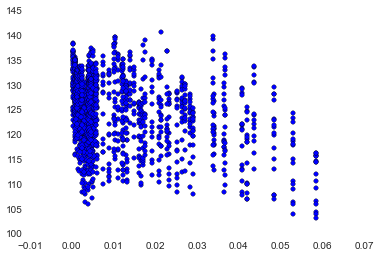

In [70]:
# Airfoil self-noise data
# Given parameters of an airfoil shape, predict how loud it will be
airfoil_data = np.loadtxt('airfoil_self_noise.dat', delimiter='\t')
airfoil_features = airfoil_data[:,:-1]
airfoil_values = airfoil_data[:,-1]
plt.scatter(airfoil_features[:,4], airfoil_values)






### Unsupervised learning
For some unsupervised learning tasks, the most relevant metrics are subjective measurements such as the apparent visual structure in a dimensional reduction approach for visualisation. 

In other tasks, particularly clustering, objective metrics of the success of the unsupervised learning are important. There are a wide range of metrics that have been developed. Some of these are *unsupervised metrics*, such as the *silhoutte coefficient*, which measures how distinct clusters are. Others are *supervised metrics* and need a set of known cluster labels to evaluate performance.




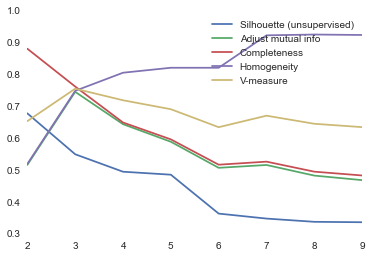

In [57]:
# this is the classic "Iris" dataset, that captures 4 attributes measured from various irises (of three distinct species)
iris = sklearn.datasets.load_iris()


def plot_clustering_performance(dataset, min_cluster, max_cluster):
    sil = []
    ami = []
    com = []
    hom = []
    vm = []
    kn = np.arange(min_cluster, max_cluster)
    for i in kn:
        # plot various metrics as a function of the number of clusters
        kmeans = sklearn.cluster.KMeans(n_clusters=i)
        clusters = kmeans.fit_predict(dataset.data)
        ami.append(sklearn.metrics.adjusted_mutual_info_score(dataset.target, clusters))
        com.append(sklearn.metrics.completeness_score(dataset.target, clusters))
        hom.append(sklearn.metrics.homogeneity_score(dataset.target, clusters))
        vm.append(sklearn.metrics.v_measure_score(dataset.target, clusters))

        sil.append(sklearn.metrics.silhouette_score(dataset.data, clusters))

    plt.plot(kn, sil)
    plt.plot(kn, ami)
    plt.plot(kn, com)
    plt.plot(kn, hom)
    plt.plot(kn, vm)
    plt.legend(["Silhouette (unsupervised)", "Adjust mutual info", "Completeness", "Homogeneity", "V-measure"])

plot_clustering_performance(iris, 2, 10)



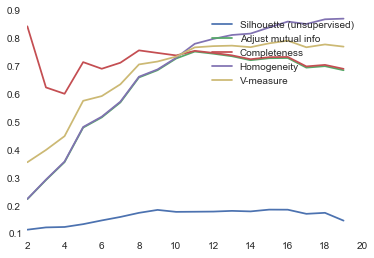

In [58]:
# WARNING: can be slow!
digits = sklearn.datasets.load_digits()
plot_clustering_performance(digits, 2, 20)

## Overfitting
Overfitting is the key issue with machine learning algorithms. It is trivially easy to devise a supervised learning algorithm that takes in input features and exactly predicts the corresponding output classes *in the training data*. A simple lookup table will do this.

To make useful predictions, a learning algorithm must predict values with features it has never seen. The problem is we can only optimise the performance based on data we *have* seen. The **generalisation** performance of an algorithm is the ablility to make predictions outside of the training data. 

This means that we cannot optimise an algorithm by adjusting parameters to fit the training data better; this will lead to **overfitting**, where the predictive power of the algorithm *decreases* as it is exposed to additional data. 

Instead, we must use a separate testing set which the training algorithm is never exposed to to evaluate performance. The importance of this can be shown in a few simple examples.

#### Polynomial overfitting
A simple example of overfitting can be seen when fitting a polynomial $y=a_0x^0 + a_1x^1 + \dots + a_qx^q$ to $n$ points. When $n=q$, the curve goes through all the points, but makes wildly inappropriate interpolations between them.

The example below shows this effect:

In [ ]:
# create some random points
n_points = 6
x = np.random.uniform(-1,1,(n_points,))
y = np.random.uniform(-1,1,(n_points,))

In [ ]:
# plot the points
plt.scatter(x,y);

We define a short function to fit and plot a polynomial fit . NumPy has a built in function `polyfit` which does least-squares fitting).

In [ ]:
def plot_poly_fit(x,y,order):    
    plt.figure()
    plt.scatter(x,y)
    # fit a polynomial
    coeffs = np.polyfit(x,y,order)
    # evaluate it across the domain
    xs = np.linspace(np.min(x),np.max(x),100)
    ys = np.polyval(coeffs, xs)
    plt.plot(xs,ys)
    

In [ ]:
plot_poly_fit(x,y,order=1) # order=1 means a linear fit

Try running the above code with increasing values for the order

#### Kernel density estimation example
We can see the same effect if we try to learn the distribution of data using **kernel density estimation** (KDE). KDE is effectively a smoothed histogram, which is created by "placing" smooth distributions on each observed data point and summing them (i.e. convolving them with some window function). This can be used to estimate an underlying smooth distribution from point samples.

The key parameter in KDE is the **kernel width** $\sigma$, which determines how wide each distribution will be and thus how smooth the overall distribution will be.

In [ ]:
# generate some random numbers -- the use of the  beta distribution isn't important, it just gives an interesting shape
x = np.random.beta(0.5, 2, 40);
# plot the data points
plt.figure()
# scatter plot showing the actual positions
plt.scatter(x,np.ones_like(x))
plt.figure()
# histogram of the data points
plt.hist(x, normed=True);

In [ ]:
import scipy.stats as stats 

# plot the kernel density estimate (Gaussian window) with the given bandwidth
def plot_kde(x, width):
    kde = stats.kde.gaussian_kde(x, bw_method=width)
    # evaluate kde estimate over range of x
    xs = np.linspace(np.min(x), np.max(x), 100) 
    plt.figure()
    plt.plot(xs, kde(xs))
    plt.scatter(x, np.ones_like(x))


In [ ]:
plot_kde(x, 2) # too smooth
plot_kde(x, 1) # a bit too smooth
plot_kde(x, 0.5) # good
plot_kde(x, 0.1) # too rough
plot_kde(x, 0.01) # just learning the data points



As the function approximates the data better, the generalisation performance drops. If we split the data randomly into two portions $X_1$ and $X_2$, and learn the KDE using only $X_1$ (training set) and then compute how likely $X_2$ (test set) is given that learned distribution, we can see this loss of generalisation performance.


In [ ]:
def split_data(x):
    # our data here is random and uncorrelated, so we can just split the array into two
    l = len(x)//2
    return x[:l], x[l:]

def learn_kde(x, width):
    return stats.kde.gaussian_kde(x,width)

def evaluate_kde(x, kde):
    # we can compute the log-likelihood by summing the log pdf evaluated at x
    return np.sum(kde.logpdf(x))


In [ ]:
def test_kde(x, width):
    # split the data into two parts, train on one, and then test it on both of the splits
    x1,x2 = split_data(x)
    kde = learn_kde(x1, width)
    # return the train log-likelihood and test log-likelihood    
    return evaluate_kde(x1, kde), evaluate_kde(x2, kde)


In [ ]:
def plot_kde_lik(x):
    # plot test and train log-likelihood as a function of 1/sigma
    widths = np.linspace(0.05, 20, 100)
    trains = []
    tests = []
    # test a bunch of widths
    for width in widths:
        train, test = test_kde(x,1.0/width)
        trains.append(train)
        tests.append(test)
        
    # plot and label
    plt.plot(widths, trains)
    plt.plot(widths, tests)
    plt.xlabel("$\sigma^{-1}$")
    plt.ylabel("Log-likelihood")
    plt.legend(["Training", "Test"])
    

We can plot the log-likelihood as a function of $\sigma^{-1}$ (the reciprocal simply makes it easier to see what is going on in the graph).

In [ ]:
plot_kde_lik(x)

### Training error can always be reduced -- but it makes things worse
We can see that test and training become better as $\sigma^{-1}$ approaches 2-4 (the exact value will depend on what random numbers we originally drew), then rapidly decreases; but the training log-likelihood **always** increases as we approximate the original data better and better.

## Data hygiene
This is why **data hygiene** is absolutely critical. If you let any part of the data you use to evaluate performance affect the train process your results are *meaningless*. 

#### Randomised selection
One approach to splitting up data is to randomly assign some elements to the training set and some to the test set (e.g. in an image classification task, 70% of the images are assigned to the training class and 30% to the test class). 

This seems like an unbiased way of separating the data, and it is for problems which are effectively uncorrelated. But imagine we have a time series $x_0, x_1, \dots, x_n$ and we build our input features $X_0, X_1, \dots$ by taking overlapping windows of the series. If we randomly choose elements of $X$, many of the elements in the test and training set may be almost identical ( because they appeared next to each other in the time series). This leads to wildly optimistic test results


#### Block selection
A much better approach here is to split the data into a large chunks. Say the data was a series of field recordings of birds taken on 10 different days; the first 6 days might be assigned as training and the last 4 as test. 

This is much more likely to be a reliable estimator of future performance, because the key idea is to *predict future behaviour* -- to learn what we have not seen. Choosing the split of training and test requires thought and domain knowledge and it is critical to make sure that the evaluation results are meaningful.



### Cross validation
Sometimes the data is too precious to split into training and test sets; there simply isn't enough of it. 

One approach to getting reliable results without overfitting is to use *cross validation*. This simply involves splitting the data into a test and training set repeatedly and averaging the results. 

#### k-fold cross validation
*k-fold* cross validation splits the data into $k$ blocks (again the block selection strategy needs to be chosen carefully to avoid overfitting) and then trains on $k-1$ of the blocks and test on the remaining one, for each of the $k$ test blocks.
#### Leave-one-out cross validation (LOOCV)
LOOCV takes this to an extreme, and splits the data into $k=n$ blocks (for $n$ data points) and trains on all but one data point and tests on the one that was left out. This is a reliable estimator of performance but can be very computationally expensive, and the benefits over $k$-fold cross validation are not always great.

 



In [ ]:
# k-fold cross validation with the KDE example

def k_split(x, k):
    # split the data into even chunks
    l = len(x)//k
    return [x[i*l:(i+1)*l] for i in range(k)]

    

In [ ]:
def test_kde_k_fold(x, width, k):
    # split the data into two parts, train on one, and then test it on both of the splits
    liks = []
    folds = k_split(x,k)
    for kn in range(k):
        # concatenate all folds *but* kn
        x1 = np.concatenate([folds[i] for i in range(k) if i!=kn])            
        # test set is the one we left out
        x2 = folds[kn]
        # fit the KDE
        kde = learn_kde(x1, width)
        # return the log-likelihood for this fold
        lik = evaluate_kde(x2, kde)
        liks.append(lik)
    return liks

In [ ]:
# now we can plot the performance with one std. dev. bounds

def plot_kde_lik_k_fold(x, k):
    # plot test and train log-likelihood as a function of 1/sigma
    widths = np.linspace(0.05, 20, 100)
    means = []
    stds = []
    # test a bunch of widths
    for width in widths:
        ks = test_kde_k_fold(x,1.0/width,k)
        means.append(np.mean(ks))
        stds.append(np.std(ks))
                
    # plot and label    
    means = np.array(means) # convert lists no numpy arrays so we can do arithmetic on them
    stds = np.array(stds)
    
    plt.fill_between(widths, means-stds, means+stds, alpha=0.1)
    plt.plot(widths, means)
    plt.xlabel("$\sigma^{-1}$")
    plt.ylabel("Log-likelihood")
    

In [ ]:
plot_kde_lik_k_fold(x, 5)

### Validation sets
Often your learning algorithms might have hyperparameters you need to estimate (e.g. learning rate). 

You absolutely **cannot** use the test set to evaluate the performance with various parameter settings and then choose the best one. This will overfit, because the test set is influencing the training performance. Train and test must be **completely** separated; no information may flow from the test data to the training process

Instead, you can create a **validation** set from the training set, and use that to tweak the hyperparameters. One common and sensible approach is to first separate off a single, fixed test set, and then use cross-validation to create multiple train and validation sets. 

#### Nested cross-validation
*Nested cross-validation* applies cross validation to both the validation and test sets, first fixing a fold split for the test set, then optimising the hyperparameters using cross-validation on the remaining data, then moving onto the next fold split for the test set, and so on.



### Baselines
Let's return to our classification example. What is good performance? Or more particularly, what is bad performance -- what's the baseline? A very simple test of whether the classifier is learning **anything** useful is to simply randomly permute the targets so they no longer correspond to the inputs. 

This estimates the chance performance of the classification process. It might be that you have a binary classification problem with exactly balanced datasets, so the baseline is 50%; but often the data is unbalanced and there are multiple classes. Permuting the targets is a very quick way to test the random performance.


#### An unbalanced example
As a simple example, we can look at a very unbalanced classifcation problem. The trees dataset includes measurements from aerial photography of land cover. A small portion of it is diseased tree growth. We can train a classifier to predict the disease status from the measurements.

In [ ]:
# load the "wilt" data set https://archive.ics.uci.edu/ml/datasets/Wilt
wilt_data = pd.read_csv("wilt.csv")
# separate features
wilt_features = wilt_data.ix[:,1:].as_matrix()

# we use label_binarize to convert "M" and "R" labels into {0,1}
# the ravel() just flattens the resulting 1D matrix into a vector
wilt_labels = sklearn.preprocessing.label_binarize(np.array(wilt_data.ix[:,0]), classes=['w', 'n']).ravel()

# split into a train and test section, holding out 20% (0.2) of the data for testing
wilt_train_features, wilt_test_features, wilt_train_labels, wilt_test_labels = sklearn.cross_validation.train_test_split(
    wilt_features, wilt_labels, test_size=0.3, random_state=0)

# fit an SVM with the default parameters
wilt_svm = sklearn.svm.SVC(C=10000, gamma=5.0)
wilt_svm.fit(wilt_train_features, wilt_train_labels)
print "Score: %f" % wilt_svm.score(wilt_test_features, wilt_test_labels)



Great! 95% accuracy!
Let's try it with random labels:

In [ ]:
wilt_svm = sklearn.svm.SVC(C=1)
wilt_svm.fit(wilt_train_features, np.random.permutation(wilt_train_labels))
print "Score: %f" % wilt_svm.score(wilt_test_features, np.random.permutation(wilt_test_labels))


The SVM learned essentially **nothing**; the accuracy is very misleading. 

In [ ]:
scores = wilt_svm.decision_function(wilt_test_features)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(wilt_test_labels, scores)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["ROC", "Chance"])

## Ensembling
Meta-algortihms are ways of combining multiple learning models to improve performance. 
These generally involve *ensembles* of classifiers. They can be applied to a very wide range of strategies, and they *generally always improve performance* (even if the improvement is marginal). In major machine learning competitions (e.g. Kaggle, the Netflix challenge) *ensemble* algorithms are almost always the top performers.

The idea of a *ensemble* method is that if you train multiple classifiers/regressors of different types or on different datasets, they will learn different things well; and combining them together increases the robustness and generalisation performance. 

### Voting hybrid models
One simple model is to train a number of different types of classifiers on a dataset and have them vote on the class label. For regression, the median or mean can be used as the combination function.

In [ ]:
# voting model on the sonar dataset

# Fit SVM
svm = sklearn.svm.SVC(C=12, gamma=0.3)
svm.fit(sonar_train_features, sonar_train_labels)
print "SVM Score: %f" % svm.score(sonar_test_features, sonar_test_labels)

# Fit KNN
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(sonar_train_features, sonar_train_labels)
print "KNN Score: %f" % knn.score(sonar_test_features, sonar_test_labels)

# Fit decision tree
dec = sklearn.tree.DecisionTreeClassifier()
dec.fit(sonar_train_features, sonar_train_labels)
print "DEC Score: %f" %dec.score(sonar_test_features, sonar_test_labels)

# predict labeels
svm_labels = svm.predict(sonar_test_features)
knn_labels = knn.predict(sonar_test_features)
dec_labels = dec.predict(sonar_test_features)

# to vote, we can take the mean and use 0.5 as a threshold
mean_labels = np.mean(np.vstack((svm_labels, knn_labels, dec_labels)), axis=0)
voted = np.where(mean_labels>0.5, 1, 0)

print "Voted score: %f" % sklearn.metrics.accuracy_score(sonar_test_labels, voted)



We can also *weight* classifiers by how well they are doing; strong classifiers should be weighted more.

### Bagging
Rather than combining different models, we can use a single model but different *datasets*. Bagging applies the statistical process called the *bootstrap* to generate multiple classifiers/regressors. 

Bootstrap generates *synthetic datasets* by randomly resampling the original dataset **with replacement**. From a dataset $X$ with $n$ elements, it generates $k$ new datasets each of which have $n$ elements consisting of random draws from the rows of $X$. Bagging just trains one classifier for each of these $k$ datasets then combines the output by voting or averaging. This increases the robustness of the model.

This has the advantage of working for *any* supervised learning task (but there may be significant computational issues if the datasets are very large). However, bagging may not improve (or may even make worse) classifiers that are not already overfitting. 

Variations of this approach include randomly sampling the features (columns of $X$); random feature selection is called *random subspaces* and randomly sampling both features and samples is known as *random patches*.


In [ ]:
# create some random points
n_points = 10
x = np.random.uniform(-1,1,(n_points,))
y = np.random.uniform(-1,1,(n_points,))

# we return to the polynomial fitting example
def bootstrap_sample(x,y):
    # resample with replacement
    indices = np.random.randint(0, len(y), len(y))
    return x[indices], y[indices]

def plot_poly_fit_bagged(x,y,order,n_bags):    
    plt.figure()
    plt.scatter(x,y)
    
    all_ys = []
    
    # fit polynomials to resampled datasets
    for i in range(n_bags):
        bx, by = bootstrap_sample(x,y)
        # fit a polynomial
        coeffs = np.polyfit(bx,by,order)
        
        # evaluate it across the domain
        xs = np.linspace(np.min(x),np.max(x),100)
        ys = np.polyval(coeffs, xs)
        all_ys.append(ys)
    
    # convert to array
    all_ys = np.array(all_ys)
    
    for ys in all_ys:
        plt.plot(xs,ys, alpha=0.05)
    plt.plot(xs, np.median(all_ys, axis=0))
    plt.ylim(-2,2)
    
plot_poly_fit(x,y, 4)
plot_poly_fit_bagged(x,y,4,100)
    


In [ ]:
# We can try bagging the mine data set

# Fit poorly generalising KNN
knn = sklearn.neighbors.KNeighborsClassifier(2)
bagged_knn = sklearn.ensemble.BaggingClassifier(knn, n_estimators=50)

knn.fit(sonar_train_features, sonar_train_labels)
print "KNN Score: %f" % knn.score(sonar_test_features, sonar_test_labels)

bagged_knn.fit(sonar_train_features, sonar_train_labels)
print "Bagged KNN Score: %f" % bagged_knn.score(sonar_test_features, sonar_test_labels)




In [ ]:
# bagging k-nn on the iris dataset
# k neareset neigbbours classification example, again with the Iris dataset
iris_2d = iris.data[:,0:2]
def plot_knn(knn):
    # plot the original data
    plt.figure()        
    # predict output value across the space
    res = 180
    xm, ym = np.meshgrid(np.linspace(0,8,res), np.linspace(0,8,res))
    zm = knn.predict(np.c_[xm.ravel(), ym.ravel()])
    zm = zm.reshape(xm.shape)
    plt.contourf(xm,ym,zm, cmap='Paired')
    plt.scatter(iris_2d[:,0], iris_2d[:,1], c=iris.target, cmap='jet')
    
# Use Euclidean norm
bagged_knn = sklearn.ensemble.BaggingClassifier(sklearn.neighbors.KNeighborsClassifier(4), n_estimators=20)
bagged_knn.fit(iris_2d, iris.target)
plot_knn(bagged_knn)

plt.figure()
knn = sklearn.neighbors.KNeighborsClassifier(4)
knn.fit(iris_2d, iris.target)
plot_knn(knn)




#### Random forests
*Random forests* use ensembles of very simple classifiers -- decision trees -- to transform a weak and poorly generalising learning model into a much more robust model. Random forests often have very competitive performance in classification tasks.


In [ ]:
# Run the test 10 times
for trials in range(20):
    forest_scores = []
    # iterate over number of trees in the ensemble
    for estimators in range(20):
        # completely randomised tree ensemble classifiers
        forest = sklearn.ensemble.ExtraTreesClassifier(n_estimators=estimators+1)
        forest.fit(sonar_train_features, sonar_train_labels)
        forest_scores.append(forest.score(sonar_test_features, sonar_test_labels))
    plt.plot(np.arange(len(forest_scores))+1, forest_scores, alpha=0.2)
plt.xlabel('No. estimators')
plt.ylabel('Accuracy')

#### Boosting
*Boosting* is an alternative ensemble method which trains a weak classifier on a dataset, identifies samples it is performing poorly on, and trains another classifier to learn the poor samples, identifies samples the ensemble is still performing poorly on, and trains a classifer to learn **those** and so on. 

The selection of the weak samples is usually done by *weighting* the samples rather than a binary inclusion/exclusion. The AdaBoost algorithm is a well-known example of this class, and can combine weak learners such as decision stumps (a decision tree with only one decision!) into effective classifiers. 

In [ ]:
dec = sklearn.tree.DecisionTreeClassifier(max_depth=1)
dec.fit(sonar_train_features, sonar_train_labels)
boost_scores = []
for estimators in range(50):
    boosted_dec = sklearn.ensemble.AdaBoostClassifier(dec, n_estimators=estimators+1, algorithm='SAMME')
    boosted_dec.fit(sonar_train_features, sonar_train_labels)
    boost_scores.append(boosted_dec.score(sonar_test_features, sonar_test_labels))
plt.axhline(dec.score(sonar_test_features, sonar_test_labels))
plt.plot(np.arange(len(boost_scores))+1, boost_scores)
plt.xlabel('No. estimators')
plt.ylabel('Accuracy')

More complex ensembles include *stacking* where a set of weak learners learn a function, and another "selection" learner learns from a combination of these classifier outputs and the original data. So each weak learner learns a function $f_1(x), f_2(x), \dots f_n(x)$, and the feature vector for the final classifier is extended to $[x_1, x_2, \dots x_d, f_1(x), f_2(x), \dots, f_n(x)]$. 

Ensemble models can be as complicated as you like, but the improvements in performance are often very small, and more complex algorithms are only worth it if marginal gains are important (as they are in competitive machine learning).